# Corner Detection

This exercise is about corner detection, or feature detection.
At the end of the exercise you should stitch two (or more) images obtained by photographs of a
panorama with the camera position in the world slightly displaced (a small camera turn, for example).
You can use the images provided as an attachment to this exercise or
images that you yourself captured/chose.

### 1) Corner detection

- a) Obtain the Harris score for each point in the image.
- b) Use Non-Maximal Supression to extract the local maxima (non maximal supression) using a 3x3 window.
- c) Highlight the keypoints obtained by plotting circles in the original image around them. Compare the points obtained by your code with the points obtained by the opencv's goodFeaturesToTrack.

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

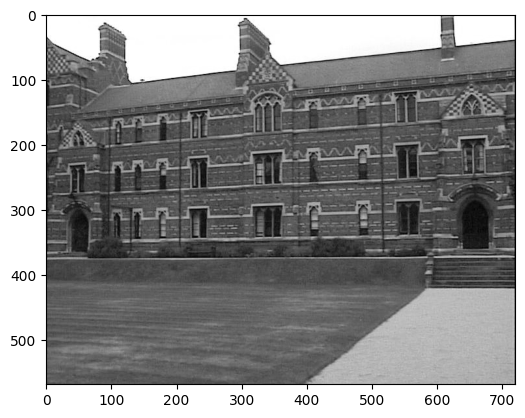

In [2]:
img = plt.imread('assets/keble_a.jpg')
impb = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(impb, cmap='gray')

In [3]:
def harris_detector(image, block_size, ksize, k):
    image = image/255.0
    
    Ix = cv2.Sobel(image, ddepth=cv2.CV_16S, dx=1, dy=0, ksize=ksize)
    Iy = cv2.Sobel(image, ddepth=cv2.CV_16S, dx=0, dy=1, ksize=ksize)
    Ix2 = cv2.Sobel(Ix, ddepth=cv2.CV_16S, dx=1, dy=0, ksize=ksize)
    Iy2 = cv2.Sobel(Iy, ddepth=cv2.CV_16S, dx=0, dy=1, ksize=ksize)
    Ixy = cv2.Sobel(Ix, ddepth=cv2.CV_16S, dx=0, dy=1, ksize=ksize)
    
    result = np.zeros(image.shape)

    for row in range(block_size, image.shape[0]-block_size):
        for col in range(block_size, image.shape[1]-block_size):
            Ix2_block = Ix2[row - ((block_size - 1)//2) : row + ((block_size - 1)//2) + 1,
                            col - ((block_size - 1)//2) : col + ((block_size - 1)//2) + 1]
            Iy2_block = Iy2[row - ((block_size - 1)//2) : row + ((block_size - 1)//2) + 1,
                            col - ((block_size - 1)//2) : col + ((block_size - 1)//2) + 1]
            Ixy_block = Ixy[row - ((block_size - 1)//2) : row + ((block_size - 1)//2) + 1,
                            col - ((block_size - 1)//2) : col + ((block_size - 1)//2) + 1]
            
            Sxx = Ix2_block.sum()
            Syy = Iy2_block.sum()
            Sxy = Ixy_block.sum()
            
            det = Sxx*Syy - Sxy**2
            trace = Sxx + Syy
            
            R = det - k * trace**2
            
            result[row, col] = R
            
    return result

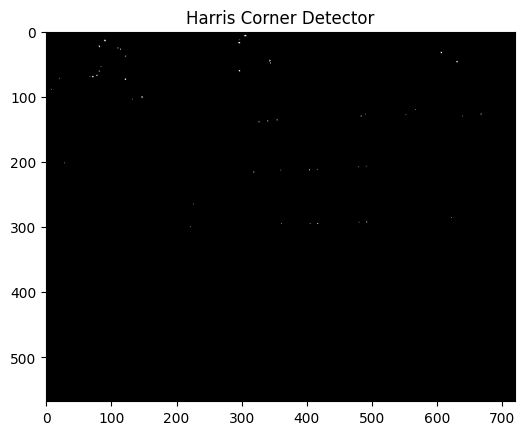

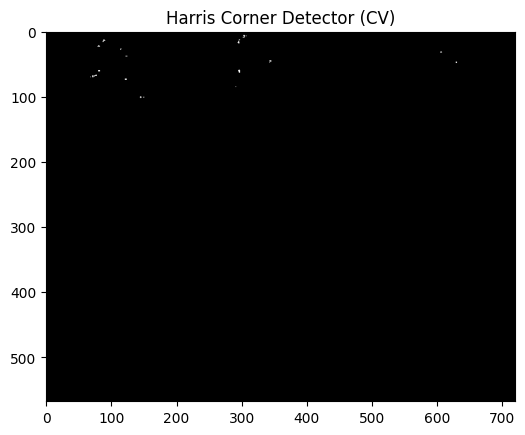

In [4]:
points = 100

result = harris_detector(impb, 3, 3, 0.075)
interest_pts = np.zeros(impb.shape)
best_scores = np.argpartition(result.flatten(), -points)[-points:]
top_row_indices, top_col_indices = np.unravel_index(best_scores, impb.shape)
interest_pts[top_row_indices, top_col_indices] = 1

plt.imshow(interest_pts, cmap='gray')
plt.title('Harris Corner Detector')
plt.show()

resultCV = cv2.cornerHarris(impb, 3, 3, 0.075)
interest_ptsCV = np.zeros(impb.shape)
topCV = np.argpartition(resultCV.flatten(), -points)[-points:]
top_row_indicescv, top_col_indicescv = np.unravel_index(topCV, impb.shape)
interest_ptsCV[top_row_indicescv, top_col_indicescv] = 1

plt.imshow(interest_ptsCV, cmap='gray')
plt.title('Harris Corner Detector (CV)')
plt.show()

In [5]:
def non_max_suppression(img, window_size):
    rows = img.shape[0]
    cols = img.shape[1]
    max = []

    for row in range(window_size, rows-window_size):
        for col in range(window_size, cols-window_size):
            window = img[row - ((window_size - 1)//2) : row + ((window_size - 1)//2) + 1,
                         col - ((window_size - 1)//2) : col + ((window_size - 1)//2) + 1]
            
            if img[row, col] >= window.max() and img[row, col] != 0:
                max.append([row, col])

    return max

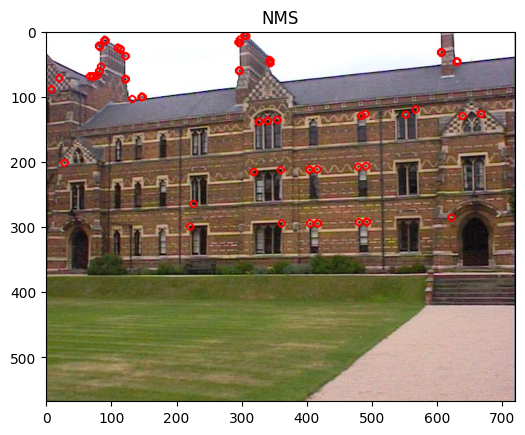

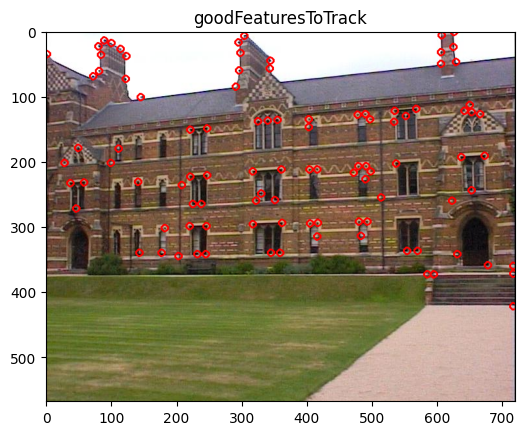

In [6]:
max = non_max_suppression(interest_pts, 3)

img_nms = plt.imread('assets/keble_a.jpg')
img_cv = plt.imread('assets/keble_a.jpg')

for i in max:
    x, y = i[1], i[0]
    cv2.circle(img = img_nms, center = (int(x), int(y)),
               radius = 5, color = (255, 0, 0), thickness = 2)

plt.imshow(img_nms)
plt.title('NMS')
plt.show()


features = cv2.goodFeaturesToTrack(image=impb, maxCorners=100, qualityLevel=0.01,
                                   minDistance = 10, blockSize=3, useHarrisDetector=True, k=0.06)

for i in features:
    x,y = i.ravel()
    cv2.circle(img = img_cv, center = (int(x), int(y)),
               radius = 5, color = (255, 0, 0), thickness = 2)

plt.imshow(img_cv)
plt.title('goodFeaturesToTrack')
plt.show()

### 2) Patches and correspondence between points

Use the functions developed in (1) to find keypoints in two images.
Go through the two images to determine the best matches between the points using
correlation between patches (build your code, do not use the ready-made opencv function).

In [7]:
npoints = 500

img_a = cv2.imread('assets/keble_a.jpg')
img_a = cv2.cvtColor(img_a, cv2.COLOR_BGR2GRAY)
result_a = harris_detector(img_a, 5, 5, 0.005)

PoI_a = np.zeros(impb.shape)
top_indices = np.argpartition(result_a.flatten(), -npoints)[-npoints:]
top_row_indices, top_col_indices = np.unravel_index(top_indices, impb.shape)

for i in range(npoints):
    PoI_a[top_row_indices[i], top_col_indices[i]] = 1

nms_a = non_max_suppression(PoI_a, 5)

img_b = cv2.imread('assets/keble_b.jpg')
img_b = cv2.cvtColor(img_b, cv2.COLOR_BGR2GRAY)
result_b = harris_detector(img_b, 5, 5, 0.005)

PoI_b = np.zeros(impb.shape)
top_indices = np.argpartition(result_b.flatten(), -npoints)[-npoints:]
top_row_indices, top_col_indices = np.unravel_index(top_indices, impb.shape)

for i in range(npoints):
    PoI_b[top_row_indices[i], top_col_indices[i]] = 1

nms_b = non_max_suppression(PoI_b, 5)

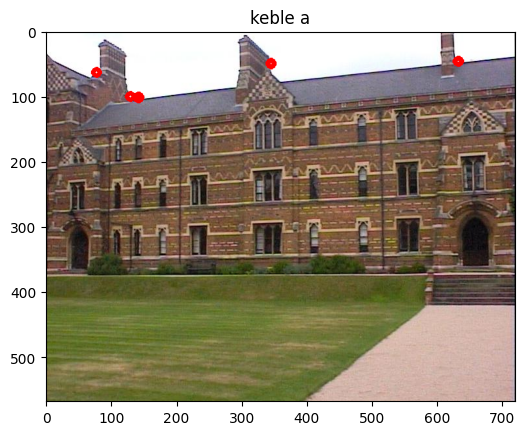

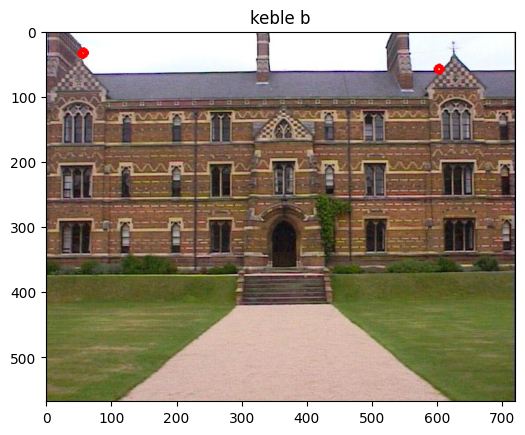

In [8]:
equiv = []
for pt_a in nms_a:
    x_a, y_a = pt_a[1], pt_a[0]
    patch_a = img_a[y_a - 1 : y_a + 2,
                    x_a - 1 : x_a + 2]
    dif = []

    for pt_b in nms_b:
        x_b, y_b = pt_b[1], pt_b[0]
        patch_b = img_b[y_b - 1 : y_b + 2,
                        x_b - 1 : x_b + 2]
        dif.append(np.sum((patch_a - patch_b) * (patch_a - patch_b)))
    
    equiv.append([pt_a, nms_b[np.argmin(dif)], np.min(dif)])

equiv.sort(key = lambda x: x[2])

img_a = plt.imread('assets/keble_a.jpg')
img_b = plt.imread('assets/keble_b.jpg')

for n in range(10):
    cv2.circle(img = img_a,center = (int(equiv[n][0][1]), int(equiv[n][0][0])),
               radius = 5, color = (255, 0, 0), thickness = 5)
    cv2.circle(img = img_b,center = (int(equiv[n][1][1]), int(equiv[n][1][0])),
               radius = 5, color = (255, 0, 0), thickness = 5)

plt.imshow(img_a)
plt.title('keble a')
plt.show()

plt.imshow(img_b)
plt.title('keble b')
plt.show()

The algorithm has identified some features correctly, although some have been confused with other portions of the image that are similar.

### 3) RANSAC

Use the RANSAC method to estimate the projective transformation H that takes points of interest from one image to their counterparts in the other image (build your code, do not use the ready-made opencv function).

In [13]:
def get_projection_matrix(src_points, dst_points):
    A = []
    for src_point, dst_point in zip(src_points, dst_points):
        x, y = src_point
        u, v = dst_point
        A.append([x, y, 1, 0, 0, 0, -u*x, -u*y, -u])
        A.append([0, 0, 0, x, y, 1, -v*x, -v*y, -v])
    A = np.asarray(A)

    U, S, V = np.linalg.svd(A)
    h = V[-1,:] / V[-1,-1]
    H = h.reshape((3,3))
    
    return H

def ransac(pts_equiv):
    result = np.zeros((3, 3))
    best_dif = np.inf

    for i in range(5):
        a, b, c, d = np.random.randint(0, len(pts_equiv), 4)
        pt_a, pt_b, pt_c, pt_d = pts_equiv[[a, b, c, d]]

        H = get_projection_matrix([pt_a[0], pt_b[0], pt_c[0], pt_d[0]], [pt_a[1], pt_b[1], pt_c[1], pt_d[1]])
    
        dif_sum = 0
        for pt in pts_equiv:
            dif_sum += np.linalg.norm((H @ np.array([pt[0][0], pt[0][1], 1]).reshape(-1, 1)) - np.array([pt[1][0], pt[1][1], 1]).reshape(-1, 1))
        
        if dif_sum < best_dif:
            best_dif = np.mean(dif_sum)
            result = H
    
    return result

Back to the example of the goal, let's estimate the projection matrix using RANSAC:

RANSAC [[ 4.70067311e-01  8.30078125e-03  1.45000000e+02]
 [-3.07602545e-01  7.80639648e-01  1.25000000e+02]
 [-5.12726138e-05  2.44140625e-05  1.00000000e+00]]


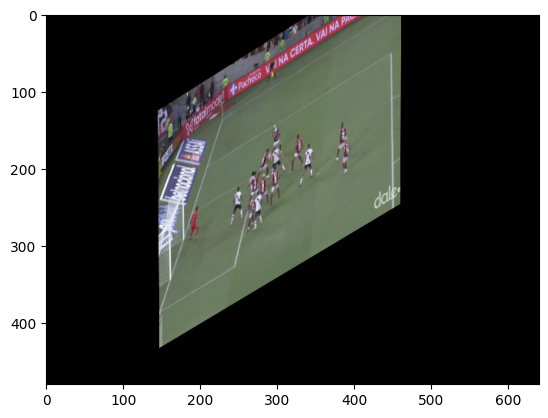

In [17]:
img_goal = plt.imread('assets/goal.jpg')

src_points = np.array([[400, 0], [0, 0], [0, 640], [400, 250]])
dst_points = np.array([[340, 2], [145, 125], [148, 615], [340, 200]])

pts_equiv = np.array([[src_points[0], dst_points[0]], [src_points[1], dst_points[1]],
                    [src_points[2], dst_points[2]], [src_points[3], dst_points[3]]])
H = ransac(pts_equiv=pts_equiv)
print("RANSAC", H)

img = cv2.warpPerspective(img_goal, H, (640, 480))
plt.imshow(img)

The result changes drastically from one execution to another. Let's evaluate OpenCV's implementation:

RANSAC [[ 4.70067311e-01  8.30078125e-03  1.45000000e+02]
 [-3.07602545e-01  7.80639648e-01  1.25000000e+02]
 [-5.12726138e-05  2.44140625e-05  1.00000000e+00]]


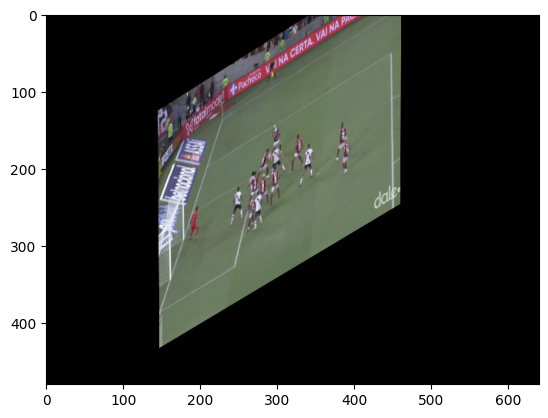

In [18]:
img_goal = plt.imread('assets/goal.jpg')

src_points = np.array([[400, 0], [0, 0], [0, 640], [400, 250]])
dst_points = np.array([[340, 2], [145, 125], [148, 615], [340, 200]])

pts_equiv = np.array([[src_points[0], dst_points[0]], [src_points[1], dst_points[1]],
                    [src_points[2], dst_points[2]], [src_points[3], dst_points[3]]])
H, status = cv2.findHomography(src_points, dst_points, cv2.RANSAC,5.0)
print("RANSAC", H)

img = cv2.warpPerspective(img_goal, H, (640, 480))
plt.imshow(img)

Not much different, just more stable.